# 作业4
# Author：陈伟钊
# （一）限定迭代时间的CG算法求解送货问题

In [1]:
import math
import numpy as np
import gurobipy as grb
import time
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False   #正常显示图像中的负号

# 初始化

In [2]:
# 初始化
# 已知位置(50,50)是仓库位置
location = [
    (50,50),  
    (50,68),
    (67,3),
    (14,73),
    (28,39),
    (75,40),
    (35,85),
    (60,6),
    (27,5),
    (76,75),
    (46,30),
    (3,50),
    (81,13),
    (5,1),
    (79,4),
    (11,55)
]
# 每个客户节点（1-15）的送货量
max_load = [30,20,15,10,15,30,25,40,40,10,50,25,40,20,10]

car_max_load = 100

per_fare = 5

# 乘上单位费用的距离矩阵(原先的距离矩阵做备份)
distance_mat = [[0 for i in range(len(location))] for j in range(len(location))]
distance_mat_init = [[0 for i in range(len(location))] for j in range(len(location))]
for i in range(len(location)):
    for j in range(len(location)):
        distance_mat[i][j] = round(math.sqrt(pow((location[i][0]-location[j][0]),2) + pow((location[i][1]-location[j][1]),2)),2)*per_fare
        distance_mat_init[i][j] = round(math.sqrt(pow((location[i][0]-location[j][0]),2) + pow((location[i][1]-location[j][1]),2)),2)*per_fare

# 记录方案成本
cost = []

# 初始化路线成本
Cr = [2*distance for distance in distance_mat[0][1:]]

# 路线是否选用客户节点
if_route_choose_node = [[0 for i in range(len(location)-1)] for j in range(len(location)-1)]
for i in range(len(location)-1):
    if_route_choose_node[i][i] = 1

# 记录每条路线的节点顺序
route = [[0,i,0] for i in range(1,16)]

# 记录时间
start = time.time()
end = time.time()

step = 0

# RMP求解

In [3]:
# rmp求解的封装函数
def rmp_solve(route,Cr,cost,if_route_choose_node):
    # 创建模型
    rmp_model = grb.Model('rmp_model')

    # 添加变量
    x = rmp_model.addVars(len(route),vtype='C',lb=0,ub=1,name='x')

    # 更新变换环境
    rmp_model.update()

    # 创建目标函数
    rmp_model.setObjective(x.prod(Cr),grb.GRB.MINIMIZE)

    # 创建约束条件
    rmp_model.addConstrs(x.prod(if_route_choose_node[i]) >= 1 for i in range(len(if_route_choose_node)))

    # 执行
    rmp_model.params.OutputFlag=0
    rmp_model.optimize()

    # 获取影子价格
    Dual = rmp_model.getAttr(grb.GRB.Attr.Pi,rmp_model.getConstrs())
    Dual.insert(0,0)
    
    # 记录方案成本
    cost.append(rmp_model.objval)
    
    return rmp_model,Dual

# 子问题求解

In [4]:
# sub求解的封装函数
def sub_solve(distance_mat,Dual,car_max_load,max_load,step):
    # 更新距离矩阵
    for i in range(len(distance_mat)):
        for j in range(len(distance_mat)):
            distance_mat[i][j] = distance_mat[i][j] - Dual[j]
            
    # 创建模型
    sub_model = grb.Model('sub_model')

    # 添加变量
    Zij={}
    for i in range(len(distance_mat)):
        for j in range(len(distance_mat)):
            Zij[i,j]=sub_model.addVar(obj=distance_mat[i][j],vtype='B',name='Zij[%s][%s]'%(i,j))
    Vi={}
    for i in range(len(distance_mat)-1):
        Vi[i] = sub_model.addVar(obj=0,vtype='C',name='Vi[%s]'%i)        
    
    # 更新变量环境
    sub_model.update()

    # 创建目标函数
    #sub_model.setObjective(grb.GRB.MINIMIZE)

    # 创建约束条件
    # 第一组约束，保证回到仓库
    sub_model.addConstr(sum(Zij[i,0] for i in range(len(distance_mat))) == 1)
    # 第二组约束，保证Vi小于货车容量上限
    for i in range(len(distance_mat)-1):
        sub_model.addConstr(Vi[i] <= car_max_load)
    # 第三组约束，保证被服务的客户可以被满足
    for i in range(len(distance_mat)-1):
        sub_model.addConstr(Vi[i] >= max_load[i])
    # 第四组约束，保证服务的先后顺序
    for i in range(len(distance_mat)-1):
        for j in range(len(distance_mat)-1):
            sub_model.addConstr(Vi[i] + (1-Zij[i+1,j+1])*car_max_load - Vi[j] - max_load[i] >= 0)
    # 第五组约束，保证从仓库出发
    sub_model.addConstr(Zij[0,0]== 0)
    sub_model.addConstr(sum(Zij[0,i] for i in range(len(distance_mat))) == 1)
    # 第六组约束，保证该方案客户不会被重复满足
    for i in range(len(distance_mat)-1):
        sub_model.addConstr(sum(Zij[i+1,j] for j in range(len(distance_mat))) <= 1)
    # 第七组约束，保证经过某节点则会从某节点再出发
    for i in range(len(distance_mat)-1):
        sub_model.addConstr(sum(Zij[i+1,j] for j in range(len(distance_mat))) - sum(Zij[j,i+1] for j in range(len(distance_mat))) == 0)
    
    # 执行
    sub_model.params.OutputFlag=0
    sub_model.params.TimeLimit=50+50*step
    sub_model.optimize()
    
    return sub_model,Zij

# 主函数

最小成本为： 3817.583333333334
选择路线0 [0, 1, 0]
选择路线5 [0, 6, 0]
选择路线7 [0, 8, 0]
选择路线8 [0, 9, 0]
选择路线10 [0, 11, 0]
选择路线15 [0, 3, 15, 4, 2, 14, 12, 0]
选择路线17 [0, 10, 7, 13, 15, 3, 0]
选择路线18 [0, 13, 7, 2, 5, 0]
选择路线19 [0, 5, 7, 13, 4, 10, 0]
选择路线28 [0, 10, 14, 12, 5, 6, 0]
程序运行时间为： 7664.61280465126


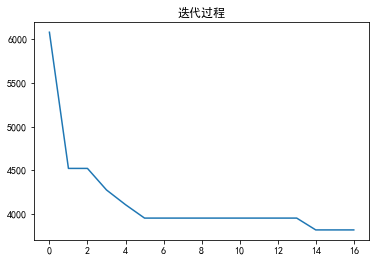

In [7]:
# 主函数
if __name__ == '__main__':
    rmp_model,Dual = rmp_solve(route,Cr,cost,if_route_choose_node)

    sub_model,Zij = sub_solve(distance_mat,Dual,car_max_load,max_load,step)

    # 更新
    # 迭代时间在2h内
    while (end - start < 7200) and (sub_model.objVal < 0):
        # 计算路线成本
        routei_Cr = 0
        for i in range(len(distance_mat_init)):
            for j in range(len(distance_mat_init)):
                routei_Cr+=distance_mat_init[i][j]*Zij[i,j].x
        Cr.append(routei_Cr)

        # 更新rmp的路线节点选择矩阵
        for i in range(1,len(distance_mat)):
            if_route_choose_node[i-1].append(sum(Zij[i,j].x for j in range(len(distance_mat))))

        # 记录路线的节点顺序
        list_save_node = []
        for i in range(len(distance_mat)):
            for j in range(len(distance_mat)):
                if Zij[i,j].x > 0:
                    list_save_node.append((i,j))
        list_save_path = [0]
        while len(list_save_path) < len(list_save_node)+1:
            for v in list_save_node:
                if list_save_path[-1] == v[0]:
                    list_save_path.append(v[1])
        route_path = list_save_path[0:len(list_save_node)+1]
        route.append(route_path)

        # 重新求解rmp
        rmp_model,Dual = rmp_solve(route,Cr,cost,if_route_choose_node)

        # 重新求解sub
        step += 1
        sub_model,Zij = sub_solve(distance_mat,Dual,car_max_load,max_load,step)
    
        # 记录结束时间
        end = time.time()

        print('最小成本为：',cost[-1])
        for i in range(len(route)):
            if rmp_model.x[i]>0:
                print('选择路线%d'%i,route[i])
        print('程序运行时间为：',end-start)
        plt.plot(cost)
        plt.title('迭代过程')
        plt.show()

根据上述结果，我们可知在限制了2h的迭代时间内，目前采用列生成算法得到的最后方案成本为3817.58，选择路线为0,5,7,8,10,15,17,18,19,28，其中不同路线可能包含了相同的客户节点。若客户仅被服务一次，则上述路线经过节点可进一步改进，对于已服务的客户节点可不用再提供送货服务，从而降低成本。同时由于在求解子问题时设置了动态求解时间限制（越往后迭代时间越多），每次求解只会得到规定时间内的满意解，因此上述方案可利用一些启发式算法再进行改进，如路线0,5,7,8,10只服务单个客户，可利用节约法进一步降低成本。但是发现上述求解子问题时变量规模以及约束条件个数过多，导致求解时间过长，并不比直接建模求解简单。下面的方法二则直接建立线性模型进行求解。

# （二）直接建立线性模型求解

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>
    
<br/>

<br/>

<br/>

<br/>

<br/>

<br/> 

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>
    
<br/>

<br/>

<br/>

<br/>

<br/>

<br/>
    
<br/>

<br/>

<br/>

<br/>

In [1]:
import math
import pandas as pd
import numpy as np
import gurobipy as grb
import time
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False   #正常显示图像中的负号

# 初始化

In [2]:
df=pd.read_excel('D:\\my_data\\cvrp.xls',sheet_name='Sheet1')
# 获取节点信息
depot=df['节点编号'][0]
N = [depot]
C = []
Q = {}
for i in range(1,df.shape[0]):
    id=df['节点编号'][i]
    demand=df['送货量'][i]
    N.append(id)
    C.append(id)
    Q[id]=int(demand)
N = grb.tuplelist(N)
C = grb.tuplelist(C)
Q = grb.tupledict(Q)

# 获取网络弧信息
location = []
for i in range(len(df)):
    location.append(tuple((df['X坐标'][i],df['Y坐标'][i])))
Cost = {}
per_fare = 5
for i in range(len(df)):
    for j in range(len(df)):
        Cost[i,j] = round(math.sqrt(pow((location[i][0]-location[j][0]),2) + pow((location[i][1]-location[j][1]),2)),0)*per_fare
Cost = grb.tupledict(Cost)

# 求解模型

In [6]:
# 封装成函数
def solveCVRPModel(depot,C,N,Q,Cost,n_vehicles=15,CAP=100):
    """
    :param depot: 车场索引
    :param C: 需求点集合
    :param N: 所有点集合
    :param Q: 需求集合
    :param Cost: 弧运输成本集合
    :param n_vehicles: 最大车辆数量
    :param CAP: 车辆容量
    :return:
    """
    # 构建车队
    K = grb.tuplelist([f'v'+str(k) for k in range(n_vehicles)])
    
    # 实例化模型
    model = grb.Model('cvrp')
    
    # 添加变量
    X = model.addVars( N,N,K,vtype=grb.GRB.BINARY,name='X[i,j,k]')
    Y = model.addVars( K,N,vtype=grb.GRB.BINARY,name='Y[k,i]')
    U = model.addVars( K,N,vtype=grb.GRB.CONTINUOUS,name='U[k,i]')
    
    # 目标函数：最小化路径成本
    z1 = grb.quicksum( Cost[i,j]*X[i,j,k] for i in N for j in N for k in K if i!=j)    
    model.setObjective(z1,grb.GRB.MINIMIZE)
    
    # 约束：需求覆盖约束
    model.addConstrs( grb.quicksum( Y[k,i] for k in K ) ==1 for i in C )
    # 约束：车辆数量约束
    model.addConstr( grb.quicksum( Y[k,depot] for k in K) == n_vehicles )
    # 约束：流平衡
    model.addConstrs( grb.quicksum( X[i,j,k] for j in N ) == grb.quicksum( X[j,i,k] for j in N ) for i in N for k in K )
    # 约束：决策变量关联
    model.addConstrs( grb.quicksum( X[i,j,k] for j in N ) == Y[k,i] for i in N for k in K )
    # 约束：容量限制
    model.addConstrs( grb.quicksum( Q[i]*Y[k,i] for i in C ) <= CAP for k in K )
    # 约束：破除子环
    model.addConstrs( U[k,i]-U[k,j]+CAP*X[i,j,k] <= CAP-Q[i] for i in C for j in C for k in K )
    model.addConstrs( Q[i] <= U[k,i] for k in K for i in C )
    model.addConstrs( U[k,i] <= CAP for k in K for i in C)
    
    # 求解
    model.params.OutputFlag=0
    model.Params.TimeLimit = 3600 # 设置求解时间上限为1h
    model.optimize()
    if model.status == grb.GRB.Status.OPTIMAL or model.status == grb.GRB.Status.TIME_LIMIT:
        print("最小成本为:{}".format(model.objVal))
        fig, ax = plt.subplots()
        for k in K:
            c = (np.random.rand(),np.random.rand(),np.random.rand())
            node_x = []
            node_y = []           
            for i in N: 
                if i == 0:
                    ax.scatter(location[i][0],location[i][1],color='black',marker='d')
                    ax.annotate('配送中心', xy=(50, 50), xytext=(60, 60),xycoords='data',arrowprops=dict(facecolor='black', shrink=0.01))
                else:
                    ax.scatter(location[i][0],location[i][1],color='black')                   
                for j in N:
                    if i!=j :
                        if X[i,j,k].x>0:
                            # print("X[{},{},{}]=1".format(i,j,k))
                            ax.plot([location[i][0],location[j][0]],[location[i][1],location[j][1]],color=c,linewidth=2)
    else:
        print("no solution")

# 主函数

最小成本为:2705.0


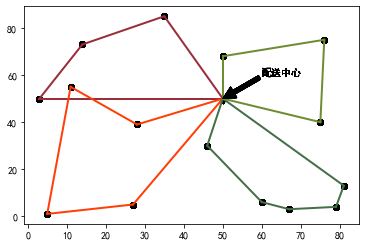

In [7]:
# 调用上述封装函数，可视化规划路径
if __name__ == '__main__':
    result = solveCVRPModel(depot,C,N,Q,Cost,n_vehicles=15,CAP=100)